In [1]:
!pip install tensorflow
!pip install tensorflow-hub
!pip install scikit-learn
!pip install keras-tuner
!pip install seaborn 

In [2]:
import os
import random
from matplotlib import pyplot as plt
import cv2

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.metrics import Precision, Recall

import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Art Style Ukiyo-e

This function returns a specified sample of labelled images in a specified directory

In [3]:
import os
import random
import pandas as pd

BASE_LOC = r'C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset'

def generate_image_df(directory, label, sample_size=None):
    data = {'filepath': [], 'label': []}

    #collect file paths and labels
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        data['filepath'].append(filepath)
        data['label'].append(label)

    #if we give a specified # of samples to use
    if sample_size is not None:
        if sample_size >= len(data['filepath']):
            return pd.DataFrame(data)  #return all if sample_size is greater or equal to the number of files
        else:
            indices = random.sample(range(len(data['filepath'])), sample_size)
            sampled_data = {key: [data[key][i] for i in indices] for key in data}
            return pd.DataFrame(sampled_data)

    return pd.DataFrame(data)


In [4]:
def artstyle_dataset(train_or_test, art_style, sample_size):
    file_location = os.path.join(BASE_LOC, 'train')

    if train_or_test == 'test':
        file_location = os.path.join(BASE_LOC, 'test')

    # half the sample size for each AI style
    ai_hum_samp = sample_size // 2

    # get human samples
    human_location = os.path.join(file_location, art_style)
    print("Location of human samples:", human_location)
    human_data = generate_image_df(human_location, "HU", sample_size)

    ai_sd_location = os.path.join(file_location, 'AI_SD_' + art_style)
    print("Location of ai_sd samples:", ai_sd_location)
    ai_sd_data = generate_image_df(ai_sd_location, 'AI', ai_hum_samp)

    ai_ld_location = os.path.join(file_location, 'AI_SD_' + art_style)
    print("Location of ai_ld samples:", ai_ld_location)
    ai_ld_data = generate_image_df(ai_ld_location, 'AI', ai_hum_samp)

    # Combine human and AI data
    dataset = pd.concat([human_data, ai_sd_data, ai_ld_data], ignore_index=True)
    
    return dataset

We create 3 dataset sizes for testing purposes to decide on the final configuration of the training model
For every art style we need 
- 1 dataset to represent 1/10 of the entire sample size for a specific generation type
- 1 dataset to represent 1/5 of the entire sample size for a specific generation type
- 1 dataset to represent 1/2 of the entire sample size for a specific generation type (target)
<br><br>
- 1 dataset tp represent a test

In [87]:
#dataset for 1/10 of artstyle samples dataset
ukiyoe_tr_1_10 = artstyle_dataset('train', 'ukiyo-e', 500)
ukiyoe_1_10_file_counts = ukiyoe_tr_1_10['label'].value_counts()
#print value count
print(f"\nLABEL COUNTS ON ukiyoe_tr_1_10 TRAINING SET")
print(ukiyoe_1_10_file_counts)
print('\n')

#dataset for 1/5 of artstyle samples dataset
ukiyoe_tr_1_5 = artstyle_dataset('train', 'ukiyo-e', 1000)
ukiyoe_1_5_file_counts = ukiyoe_tr_1_5['label'].value_counts()
#print value count
print(f"\nLABEL COUNTS ON ukiyoe_tr_1_5 TRAINING SET")
print(ukiyoe_1_5_file_counts)
print('\n')

#dataset for 1/2 of artstyle samples dataset
ukiyoe_tr_1_2 = artstyle_dataset('train', 'ukiyo-e', 2000)
ukiyoe_1_2_file_counts = ukiyoe_tr_1_2['label'].value_counts()
#print value count
print(f"\nLABEL COUNTS ON ukiyoe_tr_1_2 TRAINING SET")
print(ukiyoe_1_2_file_counts)
print('\n')

#TEST DATASET
#test set for 1/10 of artstyle samples dataset
ukiyoe_ts_1_10 = artstyle_dataset('test', 'ukiyo-e', 100)
ukiyoe_ts_1_10_file_counts = ukiyoe_ts_1_10['label'].value_counts()
#print value count
print(f"\nLABEL COUNTS ON ukiyoe_ts TESTING SET")
print(ukiyoe_ts_1_10_file_counts)
print('\n')

#test set for 1/5 of artstyle samples dataset
ukiyoe_ts_1_5 = artstyle_dataset('test', 'ukiyo-e', 200)
ukiyoe_ts_1_5_file_counts = ukiyoe_ts_1_5['label'].value_counts()
#print value count
print(f"\nLABEL COUNTS ON ukiyoe_ts TESTING SET")
print(ukiyoe_ts_1_5_file_counts)
print('\n')

#test set for 1/2 of artstyle samples dataset
ukiyoe_ts_1_2 = artstyle_dataset('test', 'ukiyo-e', 400)
ukiyoe_ts_1_2_file_counts = ukiyoe_ts_1_2['label'].value_counts()
#print value count
print(f"\nLABEL COUNTS ON ukiyoe_ts TESTING SET")
print(ukiyoe_ts_1_2_file_counts)
print('\n')


Location of human samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\train\ukiyo-e
Location of ai_sd samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\train\AI_SD_ukiyo-e
Location of ai_ld samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\train\AI_SD_ukiyo-e

LABEL COUNTS ON ukiyoe_tr_1_10 TRAINING SET
label
HU    500
AI    500
Name: count, dtype: int64


Location of human samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\train\ukiyo-e
Location of ai_sd samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\train\AI_SD_ukiyo-e
Location of ai_ld samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\train\AI_SD_ukiyo-e

LABEL COUNTS ON ukiyoe_tr_1_5 TRAINING SET
label
HU    1000
AI    1000
Name: count, dtype: int64


Location of human samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\train\ukiyo-e
Location of ai_sd samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD

## Preprocessing the 1/10 Dataset

In [6]:
from sklearn.model_selection import train_test_split

ukiyoe_tr_1_10, ukiyoe_va_1_10 = train_test_split(ukiyoe_tr_1_10, test_size=0.2, random_state=42)

#preprocess training set
ukiyoe_1_10_tr_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

ukiyoe_1_10_tr_ds = ukiyoe_1_10_tr_gen.flow_from_dataframe(
    dataframe=ukiyoe_tr_1_10,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',  
    shuffle=True
)

print (ukiyoe_1_10_tr_ds.class_indices)

#preprocess validation set
ukiyo_1_10_va_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

ukiyoe_1_10_va_ds = ukiyo_1_10_va_gen.flow_from_dataframe(
    dataframe=ukiyoe_va_1_10,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',  
    shuffle=True
)

print (ukiyoe_1_10_va_ds.class_indices)

Found 800 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Found 200 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}


## Preprocessing the 1/5 dataset

In [156]:
from sklearn.model_selection import train_test_split

ukiyoe_tr_1_5, ukiyoe_va_1_5 = train_test_split(ukiyoe_tr_1_5, test_size=0.2, random_state=42)

ukiyoe_1_5_tr_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

ukiyoe_1_5_tr_ds = ukiyoe_1_5_tr_gen.flow_from_dataframe(
    dataframe=ukiyoe_tr_1_5,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',  
    shuffle=True
)

print (ukiyoe_1_5_tr_ds.class_indices)

#preprocess validation set
ukiyoe_1_5_va_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

ukiyoe_1_5_va_ds = ukiyoe_1_5_va_gen.flow_from_dataframe(
    dataframe=ukiyoe_va_1_5,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',  
    shuffle=True
)

print (ukiyoe_1_5_va_ds.class_indices)

Found 1600 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Found 400 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}


## Preprocessing the 1/2 dataset

In [157]:
from sklearn.model_selection import train_test_split

ukiyoe_tr_1_2, ukiyoe_va_1_2 = train_test_split(ukiyoe_tr_1_5, test_size=0.2, random_state=42)

ukiyoe_1_2_tr_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

ukiyoe_1_2_tr_ds = ukiyoe_1_2_tr_gen.flow_from_dataframe(
    dataframe=ukiyoe_tr_1_2,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',  
    shuffle=True
)

print (ukiyoe_1_2_tr_ds.class_indices)

#preprocess validation set
ukiyoe_1_2_va_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

ukiyoe_1_2_va_ds = ukiyoe_1_2_va_gen.flow_from_dataframe(
    dataframe=ukiyoe_va_1_2,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',  
    shuffle=True
)

print (ukiyoe_1_2_va_ds.class_indices)



Found 1280 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Found 320 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}


## Preprocessing the test dataset

In [94]:
ukiyoe_1_10_ts_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

ukiyoe_1_10_ts_ds = ukiyoe_1_10_ts_gen.flow_from_dataframe(
    dataframe=ukiyoe_ts_1_10,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=1,
    class_mode='categorical',  
    shuffle=False
)

print (ukiyoe_1_10_ts_ds.class_indices)

ukiyoe_1_5_ts_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

ukiyoe_1_5_ts_ds = ukiyoe_1_5_ts_gen.flow_from_dataframe(
    dataframe=ukiyoe_ts_1_5,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=1,
    class_mode='categorical',  
    shuffle=False
)

print (ukiyoe_1_5_ts_ds.class_indices)

ukiyoe_1_2_ts_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

ukiyoe_1_2_ts_ds = ukiyoe_1_2_ts_gen.flow_from_dataframe(
    dataframe=ukiyoe_ts_1_2,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=1,
    class_mode='categorical',  
    shuffle=False
)

print (ukiyoe_1_2_ts_ds.class_indices)

Found 200 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Found 400 validated image filenames belonging to 2 classes.


{'AI': 0, 'HU': 1}
Found 800 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}


## CNN Setup<br>
**CNN_artstyle_frac**

In [248]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def CNN_img_ai_or_hum(filters=64, kernel_size=3, input_shape=(240, 240, 3), dense_units=64, output_units=2, activation='relu'):
    model = Sequential()
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation=activation))
    model.add(Dropout(0.5))  # Add dropout layer to reduce overfitting
    model.add(Dense(units=output_units, activation='sigmoid'))
    
    # Configure early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    return model, early_stopping

## Create the 3 models for each of the sample ratios

In [72]:
#1/10
CNN_img_ai_or_hum_ukuiyoe_1_10, CNN_img_ai_or_hum_ukuiyoe_1_10_ES = CNN_img_ai_or_hum()
CNN_img_ai_or_hum_ukuiyoe_1_10.save('compiled_models/CNN_img_ai_or_hum_ukuiyoe_1_10.keras')
#1/5
CNN_img_ai_or_hum_ukuiyoe_1_5, CNN_img_ai_or_hum_ukuiyoe_1_5_ES = CNN_img_ai_or_hum()
CNN_img_ai_or_hum_ukuiyoe_1_10.save('compiled_models/CNN_img_ai_or_hum_ukuiyoe_1_5.keras')
#1/2
CNN_img_ai_or_hum_ukuiyoe_1_2, CNN_img_ai_or_hum_ukuiyoe_1_2_ES = CNN_img_ai_or_hum()
CNN_img_ai_or_hum_ukuiyoe_1_10.save('compiled_models/CNN_img_ai_or_hum_ukuiyoe_1_2.keras')

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


## Training function

In [73]:
import time

def CNN_img_ai_or_hum_TRAIN_MODEL(model, training_dataset, validation_dataset, model_checkpoint, epochs=20):
    # Initialize total training time
    total_training_time = 0

    start_time = time.time()
    # Initial epoch count

    # Fit the model for the specified number of epochs
    history = model.fit(training_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[model_checkpoint, CNN_img_ai_or_hum_ukuiyoe_1_10_ES])

    # Calculate training time for the current batch of epochs
    training_time = time.time() - start_time
    total_training_time += training_time

    # Print total training time
    print("Total training time so far: {:.2f} seconds".format(total_training_time))

    return history

## Train the 1/10 dataset

In [74]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

#create location for check point
current_dir = os.getcwd()
filename = 'trained_models/CNN_img_ai_or_hum_ukuiyoe_1_10.keras'
checkpoint_filepath = os.path.join(current_dir, filename)

# Define the file path where the model will be saved
CNN_img_ai_or_hum_ukuiyoe_1_10_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
CNN_img_ai_or_hum_ukuiyoe_1_10.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

CNN_img_ai_or_hum_ukuiyoe_1_10_history = CNN_img_ai_or_hum_TRAIN_MODEL(CNN_img_ai_or_hum_ukuiyoe_1_10, ukiyoe_1_10_tr_ds, ukiyoe_1_10_va_ds, CNN_img_ai_or_hum_ukuiyoe_1_10_checkpoint)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5117 - loss: 326.2323
Epoch 1: val_accuracy improved from -inf to 0.79500, saving model to c:\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\trained_models/CNN_img_ai_or_hum_ukuiyoe_1_10.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.5193 - loss: 315.3870 - val_accuracy: 0.7950 - val_loss: 3.0598
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8442 - loss: 0.5972
Epoch 2: val_accuracy did not improve from 0.79500
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8449 - loss: 0.5889 - val_accuracy: 0.6950 - val_loss: 1.0972
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8360 - loss: 0.4838
Epoch 3: val_accuracy improved from 0.79500 to 0.93500, saving model to c:\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\trained_models/CNN_img_ai_or_hum_ukuiyoe_1_10.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.8401 - loss: 0.4737 - val_accuracy: 0.9350 - val_los

### Test and review 1/10 dataset

In [75]:
CNN_img_ai_or_hum_ukuiyoe_1_10_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

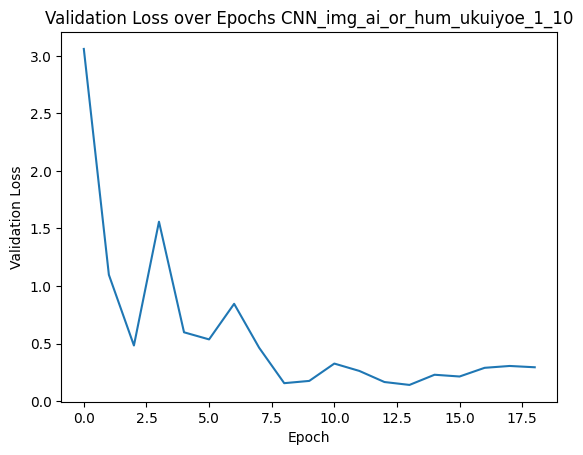

In [76]:
plt.plot(CNN_img_ai_or_hum_ukuiyoe_1_10_history.history['val_loss']);
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs CNN_img_ai_or_hum_ukuiyoe_1_10')
plt.show()

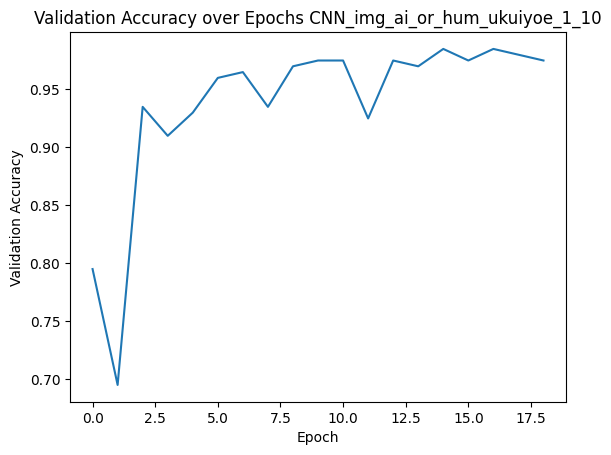

In [121]:
plt.plot(CNN_img_ai_or_hum_ukuiyoe_1_10_history.history['val_accuracy']);
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs CNN_img_ai_or_hum_ukuiyoe_1_10')
plt.show()

In [133]:
CNN_img_ai_or_hum_ukuiyoe_1_10_predictions = CNN_img_ai_or_hum_ukuiyoe_1_10.predict(ukiyoe_1_10_ts_ds)
CNN_img_ai_or_hum_ukuiyoe_1_10_predictions

200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


array([[5.43648005e-03, 9.94563520e-01],
       [8.79396737e-07, 9.99999166e-01],
       [9.13512155e-10, 1.00000000e+00],
       [2.20518632e-06, 9.99997854e-01],
       [3.01471073e-06, 9.99997020e-01],
       [5.69437398e-05, 9.99943018e-01],
       [4.82584037e-05, 9.99951720e-01],
       [3.16583049e-09, 1.00000000e+00],
       [7.00913224e-05, 9.99929905e-01],
       [5.05782249e-10, 1.00000000e+00],
       [3.67444812e-07, 9.99999642e-01],
       [8.57977511e-07, 9.99999166e-01],
       [1.71526603e-03, 9.98284757e-01],
       [1.72241125e-05, 9.99982834e-01],
       [4.39202950e-07, 9.99999523e-01],
       [3.01156472e-03, 9.96988475e-01],
       [2.51027745e-06, 9.99997497e-01],
       [1.20370621e-02, 9.87962961e-01],
       [5.12506482e-09, 1.00000000e+00],
       [9.72125008e-07, 9.99999046e-01],
       [2.75041785e-08, 1.00000000e+00],
       [2.15056048e-06, 9.99997854e-01],
       [1.06113919e-06, 9.99998927e-01],
       [9.46807916e-07, 9.99999046e-01],
       [3.548047

In [134]:
ukiyoe_1_10_ts_ds.class_indices
print (ukiyoe_1_10_ts_ds)

In [135]:
CNN_img_ai_or_hum_ukuiyoe_1_10_predictions = np.argmax(CNN_img_ai_or_hum_ukuiyoe_1_10_predictions, axis = 1)
CNN_img_ai_or_hum_ukuiyoe_1_10_predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       100
           1       0.99      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



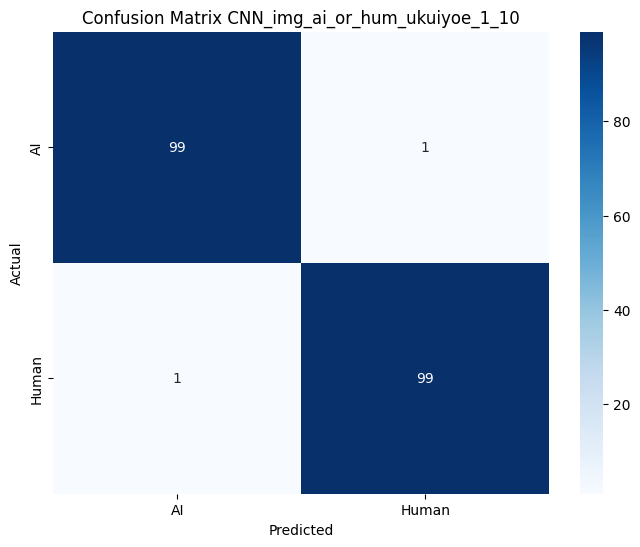

In [136]:
#import seaborn as sns 
#from sklearn.metrics import confusion_matrix, classification_report
#cm = confusion_matrix(test_dataset.classes, predictions)
#sns.heatmap(cm, annot=True)
#print(classification_report(test_dataset.classes, predictions))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix and classification report
cm = confusion_matrix(ukiyoe_1_10_ts_ds.classes, CNN_img_ai_or_hum_ukuiyoe_1_10_predictions)
report = classification_report(ukiyoe_1_10_ts_ds.classes, CNN_img_ai_or_hum_ukuiyoe_1_10_predictions)

# Define custom labels for the axes
labels = ['AI', 'Human']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

# Add labels to the axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix CNN_img_ai_or_hum_ukuiyoe_1_10')

# Print classification report
print(report)

# Show the plot
plt.show()

In [82]:
print(CNN_img_ai_or_hum_ukuiyoe_1_10_history.history)

{'accuracy': [0.6175000071525574, 0.8537499904632568, 0.893750011920929, 0.956250011920929, 0.96875, 0.9612500071525574, 0.9850000143051147, 0.9649999737739563, 0.9599999785423279, 0.9950000047683716, 0.9962499737739563, 0.9937499761581421, 0.9987499713897705, 0.9950000047683716, 1.0, 0.9987499713897705, 0.9987499713897705, 1.0, 1.0], 'loss': [174.3990478515625, 0.4805835783481598, 0.34242451190948486, 0.14314335584640503, 0.19246739149093628, 0.12007315456867218, 0.04966765269637108, 0.11926256120204926, 0.10992420464754105, 0.03195245936512947, 0.017932698130607605, 0.030864352360367775, 0.01492629386484623, 0.02137640491127968, 0.009269677102565765, 0.008777091279625893, 0.005947726778686047, 0.007107879035174847, 0.0066665769554674625], 'val_accuracy': [0.7950000166893005, 0.6949999928474426, 0.9350000023841858, 0.9100000262260437, 0.9300000071525574, 0.9599999785423279, 0.9649999737739563, 0.9350000023841858, 0.9700000286102295, 0.9750000238418579, 0.9750000238418579, 0.9250000119

### Testing with KFolds

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9927 - loss: 0.0078
      4/Unknown 0s 19ms/step - accuracy: 1.0000 - loss: 7.7486e-07

c:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 2.0856e-04
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 1.5127e-05
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0113
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9430 - loss: 0.0474
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 2.4113e-04
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0355
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0128
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0391


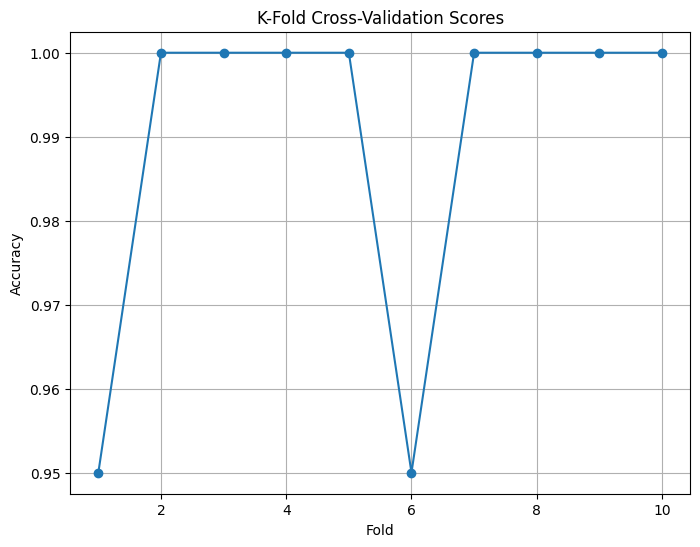

Mean CV score: 0.9899999976158143
Standard deviation of CV scores: 0.02000000476837158
Cross-validation scores: [0.949999988079071, 1.0, 1.0, 1.0, 1.0, 0.949999988079071, 1.0, 1.0, 1.0, 1.0]
DataFrame:
   Fold  Accuracy
0     1      0.95
1     2      1.00
2     3      1.00
3     4      1.00
4     5      1.00
5     6      0.95
6     7      1.00
7     8      1.00
8     9      1.00
9    10      1.00


In [117]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def k_fold_cross_validation(model, test_data, k_folds=5):
    # Initialize the k-fold cross-validation splitter
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Define a function to load batches of data for each fold
    def get_batch_data(indices):
        for idx in indices:
            X_batch, y_batch = test_data[idx]
            yield X_batch, y_batch

    # Perform k-fold cross-validation
    cross_val_scores = []
    for train_index, val_index in kf.split(test_data):
        train_data = get_batch_data(train_index)
        val_data = get_batch_data(val_index)

        # Train your model on the current fold's training data

        # Evaluate your model on the current fold's validation data
        _, accuracy = model.evaluate(val_data)
        cross_val_scores.append(accuracy)

    # Calculate the mean and standard deviation of the cross-validation scores
    mean_cv_score = np.mean(cross_val_scores)
    std_cv_score = np.std(cross_val_scores)

    # Plotting the cross-validation scores
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cross_val_scores) + 1), cross_val_scores, marker='o', linestyle='-')
    plt.title('K-Fold Cross-Validation Scores')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    # Create a DataFrame to store fold numbers and accuracy scores
    cv_scores_df = pd.DataFrame({'Fold': range(1, len(cross_val_scores) + 1), 'Accuracy': cross_val_scores})

    return cross_val_scores, mean_cv_score, std_cv_score, cv_scores_df

cross_val_scores, mean_score, std_score, cv_scores_df = k_fold_cross_validation(CNN_img_ai_or_hum_ukuiyoe_1_10, ukiyoe_1_10_ts_ds, 10)
print("Mean CV score:", mean_score)
print("Standard deviation of CV scores:", std_score)
print("Cross-validation scores:", cross_val_scores)
print("DataFrame:")
print(cv_scores_df)


## Train 1/5 dataset

In [83]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

#create location for check point
current_dir = os.getcwd()
filename = 'trained_models/CNN_img_ai_or_hum_ukuiyoe_1_5.keras'
checkpoint_filepath = os.path.join(current_dir, filename)

# Define the file path where the model will be saved
CNN_img_ai_or_hum_ukuiyoe_1_5_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
CNN_img_ai_or_hum_ukuiyoe_1_5.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

CNN_img_ai_or_hum_ukuiyoe_1_5_history = CNN_img_ai_or_hum_TRAIN_MODEL(CNN_img_ai_or_hum_ukuiyoe_1_5, ukiyoe_1_5_tr_ds, ukiyoe_1_5_va_ds, CNN_img_ai_or_hum_ukuiyoe_1_5_checkpoint)

Epoch 1/20


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5883 - loss: 297.1021
Epoch 1: val_accuracy improved from -inf to 0.83750, saving model to c:\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\trained_models/CNN_img_ai_or_hum_ukuiyoe_1_5.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.5918 - loss: 290.4524 - val_accuracy: 0.8375 - val_loss: 0.4663
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8803 - loss: 0.4373
Epoch 2: val_accuracy improved from 0.83750 to 0.92000, saving model to c:\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\trained_models/CNN_img_ai_or_hum_ukuiyoe_1_5.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.8797 - loss: 0.4371 - val_accuracy: 0.9200 - val_loss: 0.3798
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9601 - loss: 0.2063
Epoch 3: val_accuracy improved from 0.92000 to 0.98750, saving model to c:\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\trained_models/CNN_img_ai_or_hum_ukuiyo

### Test and review 1/5 dataset

In [118]:
CNN_img_ai_or_hum_ukuiyoe_1_5_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

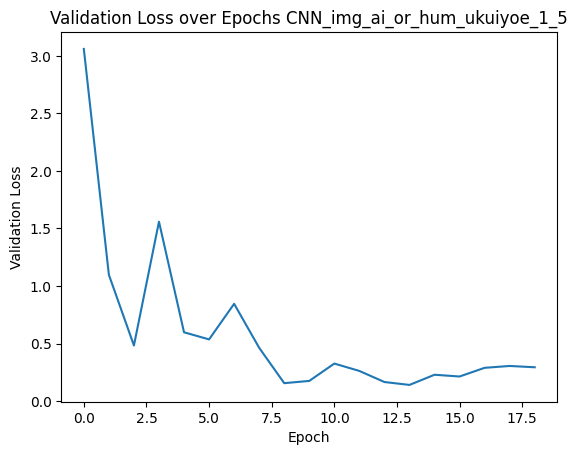

In [120]:
plt.plot(CNN_img_ai_or_hum_ukuiyoe_1_10_history.history['val_loss']);
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs CNN_img_ai_or_hum_ukuiyoe_1_5')
plt.show()

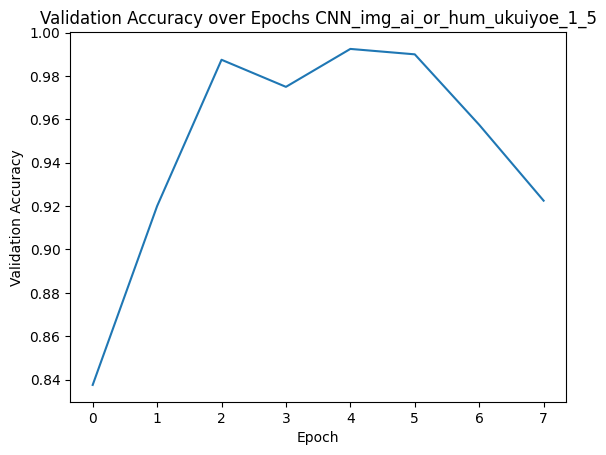

In [122]:
plt.plot(CNN_img_ai_or_hum_ukuiyoe_1_5_history.history['val_accuracy']);
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs CNN_img_ai_or_hum_ukuiyoe_1_5')
plt.show()

In [146]:
CNN_img_ai_or_hum_ukuiyoe_1_5_predictions = CNN_img_ai_or_hum_ukuiyoe_1_5.predict(ukiyoe_1_5_ts_ds)
CNN_img_ai_or_hum_ukuiyoe_1_5_predictions

400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step


array([[1.00564241e-08, 1.00000000e+00],
       [1.24347342e-12, 1.00000000e+00],
       [8.21134388e-01, 1.78865582e-01],
       [1.62623994e-12, 1.00000000e+00],
       [1.89942890e-03, 9.98100579e-01],
       [1.35646416e-09, 1.00000000e+00],
       [4.28737141e-04, 9.99571264e-01],
       [7.68115779e-12, 1.00000000e+00],
       [2.54554232e-03, 9.97454464e-01],
       [3.31692182e-12, 1.00000000e+00],
       [8.49946577e-04, 9.99150038e-01],
       [3.36401601e-10, 1.00000000e+00],
       [2.94314106e-07, 9.99999762e-01],
       [6.57954661e-04, 9.99342024e-01],
       [5.40508470e-03, 9.94594872e-01],
       [7.40832773e-09, 1.00000000e+00],
       [2.48168902e-07, 9.99999762e-01],
       [1.34508298e-06, 9.99998689e-01],
       [3.13979220e-09, 1.00000000e+00],
       [6.99098592e-08, 9.99999881e-01],
       [6.89609392e-09, 1.00000000e+00],
       [4.63311706e-04, 9.99536753e-01],
       [1.01787296e-12, 1.00000000e+00],
       [6.24527931e-02, 9.37547207e-01],
       [5.143790

In [132]:
ukiyoe_1_5_ts_ds.class_indices
print (ukiyoe_1_5_ts_ds)

In [137]:
CNN_img_ai_or_hum_ukuiyoe_1_5_predictions = np.argmax(CNN_img_ai_or_hum_ukuiyoe_1_5_predictions, axis = 1)
CNN_img_ai_or_hum_ukuiyoe_1_5_predictions

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       0.99      0.98      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



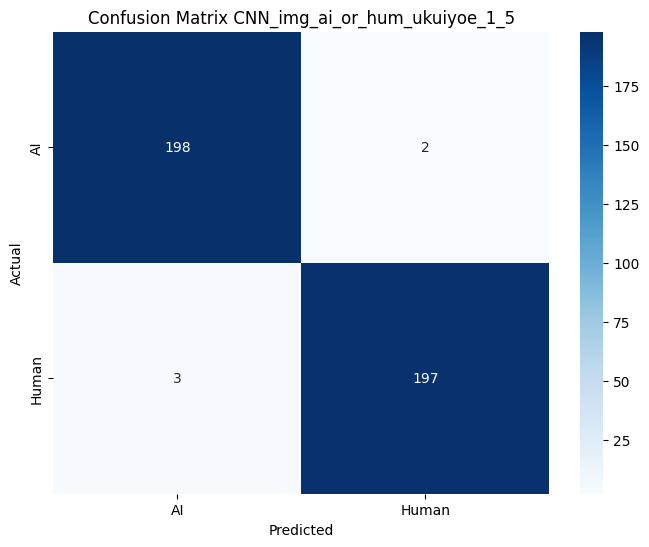

In [139]:
#import seaborn as sns 
#from sklearn.metrics import confusion_matrix, classification_report
#cm = confusion_matrix(test_dataset.classes, predictions)
#sns.heatmap(cm, annot=True)
#print(classification_report(test_dataset.classes, predictions))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix and classification report
cm = confusion_matrix(ukiyoe_1_5_ts_ds.classes, CNN_img_ai_or_hum_ukuiyoe_1_5_predictions)
report = classification_report(ukiyoe_1_5_ts_ds.classes, CNN_img_ai_or_hum_ukuiyoe_1_5_predictions)

# Define custom labels for the axes
labels = ['AI', 'Human']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

# Add labels to the axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix CNN_img_ai_or_hum_ukuiyoe_1_5')

# Print classification report
print(report)

# Show the plot
plt.show()

### Testing with KFolds

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9613 - loss: 0.2979
      1/Unknown 0s 72ms/step - accuracy: 1.0000 - loss: 0.0000e+00

c:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0073
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0019
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 0.0049
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0245
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8950 - loss: 0.2032
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9804 - loss: 0.3713
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0092
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0093
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9507 - loss: 0.0407


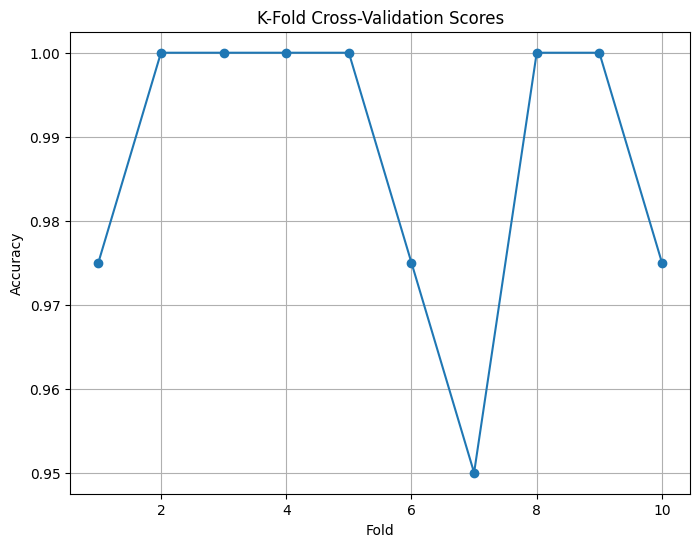

Mean CV score: 0.9875000059604645
Standard deviation of CV scores: 0.01677050716565191
Cross-validation scores: [0.9750000238418579, 1.0, 1.0, 1.0, 1.0, 0.9750000238418579, 0.949999988079071, 1.0, 1.0, 0.9750000238418579]
DataFrame:
   Fold  Accuracy
0     1     0.975
1     2     1.000
2     3     1.000
3     4     1.000
4     5     1.000
5     6     0.975
6     7     0.950
7     8     1.000
8     9     1.000
9    10     0.975


In [150]:
cross_val_scores, mean_score, std_score, cv_scores_df = k_fold_cross_validation(CNN_img_ai_or_hum_ukuiyoe_1_5, ukiyoe_1_5_ts_ds, 10)
print("Mean CV score:", mean_score)
print("Standard deviation of CV scores:", std_score)
print("Cross-validation scores:", cross_val_scores)
print("DataFrame:")
print(cv_scores_df)

## Train 1/2 dataset

In [140]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

#create location for check point
current_dir = os.getcwd()
filename = 'trained_models/CNN_img_ai_or_hum_ukuiyoe_1_2.keras'
checkpoint_filepath = os.path.join(current_dir, filename)

# Define the file path where the model will be saved
CNN_img_ai_or_hum_ukuiyoe_1_2_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
CNN_img_ai_or_hum_ukuiyoe_1_2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

CNN_img_ai_or_hum_ukuiyoe_1_2_history = CNN_img_ai_or_hum_TRAIN_MODEL(CNN_img_ai_or_hum_ukuiyoe_1_2, ukiyoe_1_2_tr_ds, ukiyoe_1_2_va_ds, CNN_img_ai_or_hum_ukuiyoe_1_2_checkpoint)

Epoch 1/20


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4908 - loss: 1043.4100
Epoch 1: val_accuracy improved from -inf to 0.57187, saving model to c:\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\trained_models/CNN_img_ai_or_hum_ukuiyoe_1_2.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.4931 - loss: 1015.2852 - val_accuracy: 0.5719 - val_loss: 0.7303
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7657 - loss: 0.5057
Epoch 2: val_accuracy improved from 0.57187 to 0.95625, saving model to c:\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\trained_models/CNN_img_ai_or_hum_ukuiyoe_1_2.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 0.7687 - loss: 0.5022 - val_accuracy: 0.9563 - val_loss: 0.3700
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9498 - loss: 0.2479
Epoch 3: val_accuracy did not improve from 0.95625
20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.9499 - loss: 0.2480 - val_accuracy: 0.9312 - val_loss: 0.3101

### Test and review 1/10 dataset

In [142]:
CNN_img_ai_or_hum_ukuiyoe_1_2_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

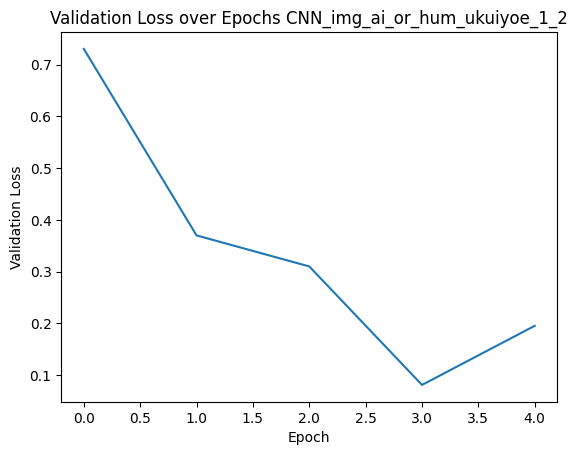

In [143]:
plt.plot(CNN_img_ai_or_hum_ukuiyoe_1_2_history.history['val_loss']);
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs CNN_img_ai_or_hum_ukuiyoe_1_2')
plt.show()

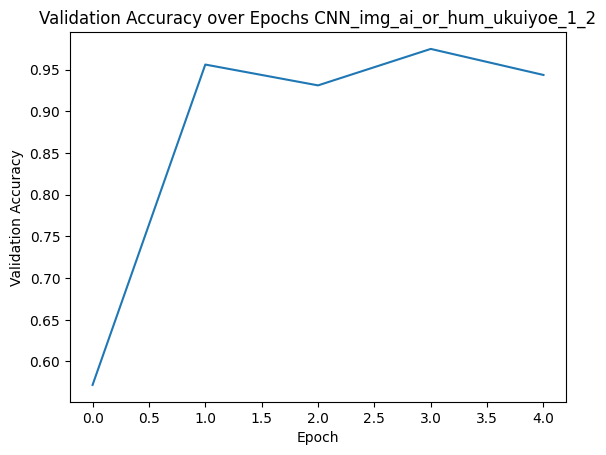

In [145]:
plt.plot(CNN_img_ai_or_hum_ukuiyoe_1_2_history.history['val_accuracy']);
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs CNN_img_ai_or_hum_ukuiyoe_1_2')
plt.show()

In [147]:
CNN_img_ai_or_hum_ukuiyoe_1_2_predictions = CNN_img_ai_or_hum_ukuiyoe_1_5.predict(ukiyoe_1_2_ts_ds)
CNN_img_ai_or_hum_ukuiyoe_1_2_predictions

800/800 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step


array([[1.1199764e-12, 1.0000000e+00],
       [3.8293465e-06, 9.9999619e-01],
       [1.8773247e-09, 1.0000000e+00],
       ...,
       [1.0000000e+00, 2.6224818e-26],
       [1.0000000e+00, 1.3217663e-30],
       [1.0000000e+00, 1.0417649e-23]], dtype=float32)

In [148]:
ukiyoe_1_2_ts_ds.class_indices
print (ukiyoe_1_2_ts_ds)

In [149]:
CNN_img_ai_or_hum_ukuiyoe_1_2_predictions = np.argmax(CNN_img_ai_or_hum_ukuiyoe_1_2_predictions, axis = 1)
CNN_img_ai_or_hum_ukuiyoe_1_2_predictions

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Testing with KFolds

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2994 - loss: 1.2124
      7/Unknown 0s 18ms/step - accuracy: 0.3908 - loss: 0.9390

c:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3595 - loss: 0.8877
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2820 - loss: 1.1724
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2986 - loss: 0.8689
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3073 - loss: 1.3277
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3262 - loss: 0.9493
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3414 - loss: 0.9852
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2981 - loss: 0.8893
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3765 - loss: 1.0188
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3265 - loss: 0.7806


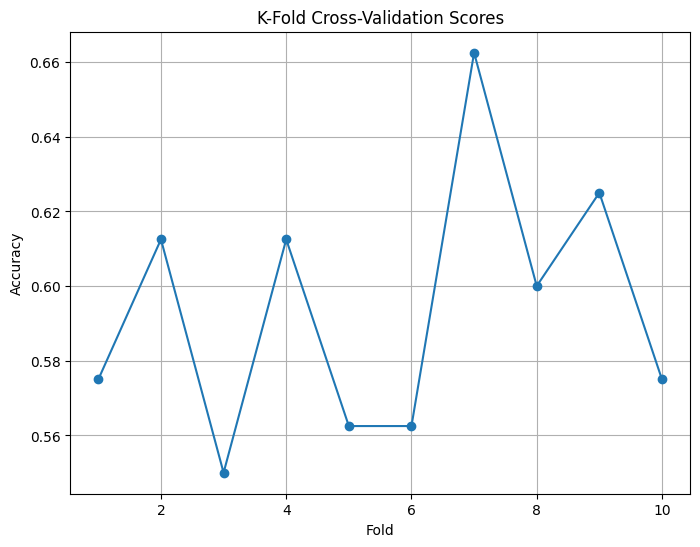

Mean CV score: 0.5937500059604645
Standard deviation of CV scores: 0.033189801628419294
Cross-validation scores: [0.574999988079071, 0.612500011920929, 0.550000011920929, 0.612500011920929, 0.5625, 0.5625, 0.6625000238418579, 0.6000000238418579, 0.625, 0.574999988079071]
DataFrame:
   Fold  Accuracy
0     1    0.5750
1     2    0.6125
2     3    0.5500
3     4    0.6125
4     5    0.5625
5     6    0.5625
6     7    0.6625
7     8    0.6000
8     9    0.6250
9    10    0.5750


In [151]:
cross_val_scores, mean_score, std_score, cv_scores_df = k_fold_cross_validation(CNN_img_ai_or_hum_ukuiyoe_1_2, ukiyoe_1_2_ts_ds, 10)
print("Mean CV score:", mean_score)
print("Standard deviation of CV scores:", std_score)
print("Cross-validation scores:", cross_val_scores)
print("DataFrame:")
print(cv_scores_df)

# Art Style Realism

In [198]:
#dataset for 1/10 of artstyle samples dataset
realism_tr_1_10 = artstyle_dataset('train', 'realism', 500)
realism_1_10_file_counts = realism_tr_1_10['label'].value_counts()
#print value count
print(f"\nLABEL COUNTS ON ukiyoe_tr_1_10 TRAINING SET")
print(realism_1_10_file_counts)
print('\n')

#dataset for 1/5 of artstyle samples dataset
realism_tr_1_5 = artstyle_dataset('train', 'realism', 1000)
realism_1_5_file_counts = realism_tr_1_5['label'].value_counts()
#print value count
print(f"\nLABEL COUNTS ON ukiyoe_tr_1_5 TRAINING SET")
print(realism_1_5_file_counts)
print('\n')

#dataset for 1/2 of artstyle samples dataset
realism_tr_1_2 = artstyle_dataset('train', 'realism', 2000)
realism_1_2_file_counts = realism_tr_1_2['label'].value_counts()
#print value count
print(f"\nLABEL COUNTS ON ukiyoe_tr_1_2 TRAINING SET")
print(realism_1_2_file_counts)
print('\n')

#TEST DATASET
#test set for 1/10 of artstyle samples dataset
realism_ts_1_10 = artstyle_dataset('test', 'realism', 100)
realism_ts_1_10_file_counts = realism_ts_1_10['label'].value_counts()
#print value count
print(f"\nLABEL COUNTS ON ukiyoe_ts TESTING SET")
print(realism_ts_1_10_file_counts)
print('\n')

#test set for 1/5 of artstyle samples dataset
realism_ts_1_5 = artstyle_dataset('test', 'realism', 200)
realism_ts_1_5_file_counts = ukiyoe_ts_1_5['label'].value_counts()
#print value count
print(f"\nLABEL COUNTS ON ukiyoe_ts TESTING SET")
print(realism_ts_1_5_file_counts)
print('\n')

#test set for 1/2 of artstyle samples dataset
realism_ts_1_2 = artstyle_dataset('test', 'realism', 400)
realism_ts_1_2_file_counts = realism_ts_1_2['label'].value_counts()
#print value count
print(f"\nLABEL COUNTS ON ukiyoe_ts TESTING SET")
print(realism_ts_1_2_file_counts)
print('\n')


Location of human samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\train\realism
Location of ai_sd samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\train\AI_SD_realism
Location of ai_ld samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\train\AI_SD_realism

LABEL COUNTS ON ukiyoe_tr_1_10 TRAINING SET
label
HU    500
AI    500
Name: count, dtype: int64


Location of human samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\train\realism
Location of ai_sd samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\train\AI_SD_realism
Location of ai_ld samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\train\AI_SD_realism

LABEL COUNTS ON ukiyoe_tr_1_5 TRAINING SET
label
HU    1000
AI    1000
Name: count, dtype: int64


Location of human samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\train\realism
Location of ai_sd samples: C:\\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD

## Preprocessing the 1/10 Dataset

In [199]:
from sklearn.model_selection import train_test_split

realism_tr_1_10, realism_va_1_10 = train_test_split(realism_tr_1_10, test_size=0.2, random_state=42)

#preprocess training set
realism_1_10_tr_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

realism_1_10_tr_ds = realism_1_10_tr_gen.flow_from_dataframe(
    dataframe=realism_tr_1_10,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',  
    shuffle=True
)

print (realism_1_10_tr_ds.class_indices)

#preprocess validation set
realism_1_10_va_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

realism_1_10_va_ds = realism_1_10_va_gen.flow_from_dataframe(
    dataframe=realism_va_1_10,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',  
    shuffle=True
)

print (realism_1_10_va_ds.class_indices)

Found 800 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Found 200 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}


## Preprocessing the 1/5 dataset

In [200]:
from sklearn.model_selection import train_test_split

realism_tr_1_5, realism_va_1_5 = train_test_split(realism_tr_1_5, test_size=0.2, random_state=42)

realism_1_5_tr_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

realism_1_5_tr_ds = realism_1_5_tr_gen.flow_from_dataframe(
    dataframe=realism_tr_1_5,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',  
    shuffle=True
)

print (realism_1_5_tr_ds.class_indices)

#preprocess validation set
realism_1_5_va_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

realism_1_5_va_ds = realism_1_5_va_gen.flow_from_dataframe(
    dataframe=realism_va_1_5,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',  
    shuffle=True
)

print (realism_1_5_va_ds.class_indices)

Found 1600 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Found 400 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}


## Preprocessing the 1/2 dataset

In [201]:
from sklearn.model_selection import train_test_split

realism_tr_1_2, realism_va_1_2 = train_test_split(realism_tr_1_5, test_size=0.2, random_state=42)

realism_1_2_tr_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

realism_1_2_tr_ds = realism_1_2_tr_gen.flow_from_dataframe(
    dataframe=realism_tr_1_2,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',  
    shuffle=True
)

print (realism_1_2_tr_ds.class_indices)

#preprocess validation set
realism_1_2_va_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

realism_1_2_va_ds = realism_1_2_va_gen.flow_from_dataframe(
    dataframe=realism_va_1_2,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',  
    shuffle=True
)

print (realism_1_2_va_ds.class_indices)

Found 1280 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Found 320 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}


## Preprocessing the test dataset

In [202]:
realism_1_10_ts_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

realism_1_10_ts_ds = realism_1_10_ts_gen.flow_from_dataframe(
    dataframe=realism_ts_1_10,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=1,
    class_mode='categorical',  
    shuffle=False
)

print (realism_1_10_ts_ds.class_indices)

realism_1_5_ts_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

realism_1_5_ts_ds = realism_1_5_ts_gen.flow_from_dataframe(
    dataframe=realism_ts_1_5,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=1,
    class_mode='categorical',  
    shuffle=False
)

print (realism_1_5_ts_ds.class_indices)

realism_1_2_ts_gen = ImageDataGenerator(
    #rescale=1./255,   # to normalize pixel value
    #rotation_range=7, # it will apply rotations to the image
    #horizontal_flip=True, # it will flip image horizontally
    #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

realism_1_2_ts_ds = realism_1_2_ts_gen.flow_from_dataframe(
    dataframe=realism_ts_1_2,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=1,
    class_mode='categorical',  
    shuffle=False
)

print (realism_1_2_ts_ds.class_indices)

Found 200 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Found 400 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Found 800 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}


## Create the 3 models for each of the sample ratios

In [250]:
#1/10
CNN_img_ai_or_hum_realism_1_10, CNN_img_ai_or_hum_realism_1_10_ES = CNN_img_ai_or_hum()
CNN_img_ai_or_hum_realism_1_10.save('compiled_models/CNN_img_ai_or_hum_realism_1_10.keras')
#1/5
CNN_img_ai_or_hum_realism_1_5, CNN_img_ai_or_hum_realism_1_5_ES = CNN_img_ai_or_hum()
CNN_img_ai_or_hum_realism_1_10.save('compiled_models/CNN_img_ai_or_hum_realism_1_5.keras')
#1/2
CNN_img_ai_or_hum_realism_1_2, CNN_img_ai_or_hum_realism_1_2_ES = CNN_img_ai_or_hum()
CNN_img_ai_or_hum_realism_1_10.save('compiled_models/CNN_img_ai_or_hum_realism_1_2.keras')

## Train the 1/10 dataset

In [251]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

#create location for check point
current_dir = os.getcwd()
filename = 'trained_models/CNN_img_ai_or_hum_realism_1_10.keras'
checkpoint_filepath = os.path.join(current_dir, filename)

# Define the file path where the model will be saved
CNN_img_ai_or_hum_realism_1_10_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
CNN_img_ai_or_hum_realism_1_10.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

CNN_img_ai_or_hum_realism_1_10_history = CNN_img_ai_or_hum_TRAIN_MODEL(CNN_img_ai_or_hum_realism_1_10, realism_1_10_tr_ds, realism_1_10_va_ds, CNN_img_ai_or_hum_realism_1_10_checkpoint)

Epoch 1/20


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4814 - loss: 537.4682
Epoch 1: val_accuracy improved from -inf to 0.66000, saving model to c:\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\trained_models/CNN_img_ai_or_hum_realism_1_10.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.4854 - loss: 517.2739 - val_accuracy: 0.6600 - val_loss: 0.6316
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6999 - loss: 0.6045
Epoch 2: val_accuracy improved from 0.66000 to 0.69500, saving model to c:\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\trained_models/CNN_img_ai_or_hum_realism_1_10.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.6997 - loss: 0.6053 - val_accuracy: 0.6950 - val_loss: 0.6257
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8140 - loss: 0.4904
Epoch 3: val_accuracy improved from 0.69500 to 0.73000, saving model to c:\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\trained_models/CNN_img_ai_or_hum_real

### Test and REview 1/10 dataset

In [252]:
CNN_img_ai_or_hum_realism_1_10_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

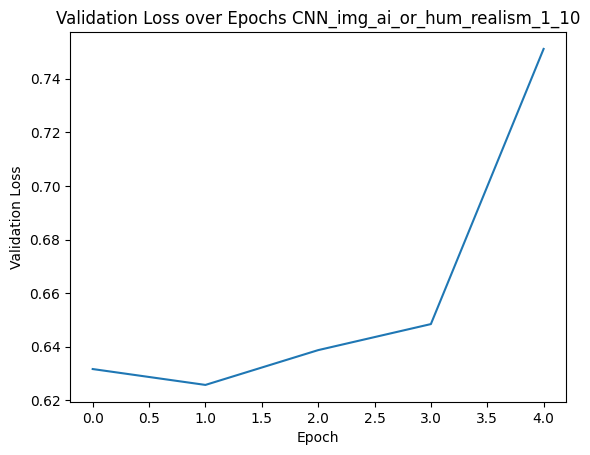

In [253]:
plt.plot(CNN_img_ai_or_hum_realism_1_10_history.history['val_loss']);
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs CNN_img_ai_or_hum_realism_1_10')
plt.show()

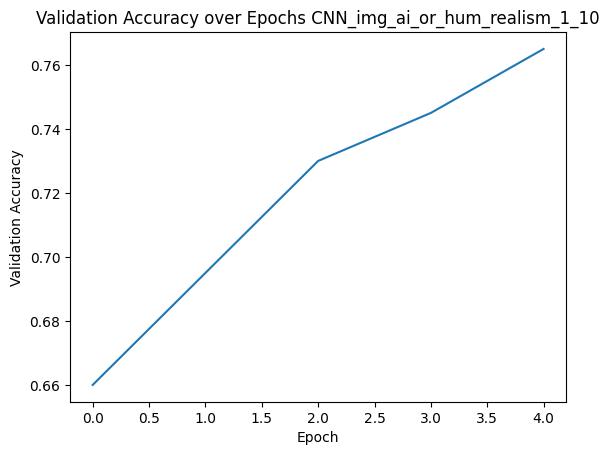

In [254]:
plt.plot(CNN_img_ai_or_hum_realism_1_10_history.history['val_accuracy']);
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs CNN_img_ai_or_hum_realism_1_10')
plt.show()

In [255]:
CNN_img_ai_or_hum_realism_1_10_predictions = CNN_img_ai_or_hum_realism_1_10.predict(realism_1_10_ts_ds)
CNN_img_ai_or_hum_realism_1_10_predictions

 30/200 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step

200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


array([[5.1429647e-01, 5.0911313e-01],
       [2.3943143e-01, 7.8644669e-01],
       [5.0921190e-01, 4.9218848e-01],
       [3.2295075e-01, 6.5777057e-01],
       [4.2037326e-01, 5.6235254e-01],
       [5.1598382e-01, 5.1902497e-01],
       [4.3787026e-01, 5.8212399e-01],
       [4.3879288e-01, 6.0307527e-01],
       [1.3863029e-01, 9.0416938e-01],
       [4.3524745e-01, 6.1024874e-01],
       [4.8879853e-01, 5.1666200e-01],
       [3.1553924e-01, 6.2594533e-01],
       [4.6329275e-01, 5.5889708e-01],
       [4.9404091e-01, 5.0865304e-01],
       [4.5545360e-01, 5.5299556e-01],
       [4.0705895e-01, 5.8090055e-01],
       [4.4078061e-01, 6.1761862e-01],
       [3.7935141e-01, 6.3255590e-01],
       [3.3831111e-01, 6.6360772e-01],
       [5.4466259e-01, 5.4929817e-01],
       [4.4423050e-01, 6.1982954e-01],
       [4.9506572e-01, 5.0771666e-01],
       [4.9730757e-01, 5.6979465e-01],
       [3.6102170e-01, 6.3617015e-01],
       [4.2509732e-01, 5.7582474e-01],
       [1.6875710e-01, 9.

In [256]:
realism_1_10_ts_ds.class_indices
print (realism_1_10_ts_ds)

In [257]:
CNN_img_ai_or_hum_realism_1_10_predictions = np.argmax(CNN_img_ai_or_hum_realism_1_10_predictions, axis = 1)
CNN_img_ai_or_hum_realism_1_10_predictions

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0], dtype=int64)

              precision    recall  f1-score   support

           0       0.79      0.58      0.67       100
           1       0.67      0.85      0.75       100

    accuracy                           0.71       200
   macro avg       0.73      0.71      0.71       200
weighted avg       0.73      0.71      0.71       200



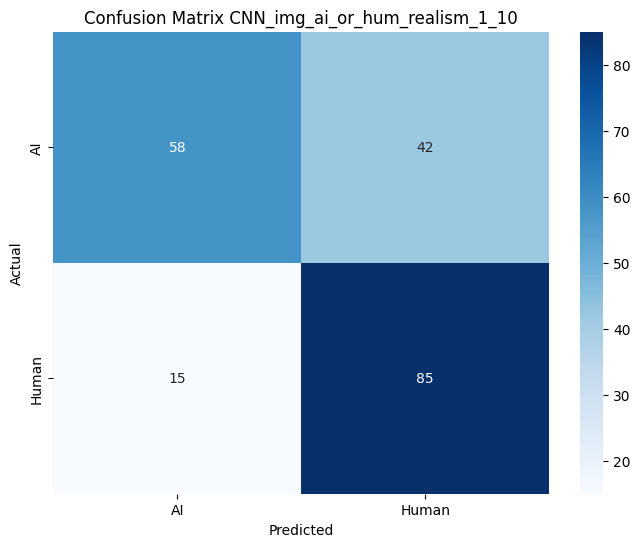

In [258]:
#import seaborn as sns 
#from sklearn.metrics import confusion_matrix, classification_report
#cm = confusion_matrix(test_dataset.classes, predictions)
#sns.heatmap(cm, annot=True)
#print(classification_report(test_dataset.classes, predictions))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix and classification report
cm = confusion_matrix(realism_1_10_ts_ds.classes, CNN_img_ai_or_hum_realism_1_10_predictions)
report = classification_report(realism_1_10_ts_ds.classes, CNN_img_ai_or_hum_realism_1_10_predictions)

# Define custom labels for the axes
labels = ['AI', 'Human']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

# Add labels to the axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix CNN_img_ai_or_hum_realism_1_10')

# Print classification report
print(report)

# Show the plot
plt.show()

### Testing with KFolds

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7055 - loss: 0.6311
      1/Unknown 0s 86ms/step - accuracy: 1.0000 - loss: 0.5326

c:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8332 - loss: 0.5935


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8899 - loss: 0.5588
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7051 - loss: 0.6465
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6267 - loss: 0.6388
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6867 - loss: 0.6146
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8879 - loss: 0.4606
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9168 - loss: 0.4966
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9021 - loss: 0.6046
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8994 - loss: 0.4947


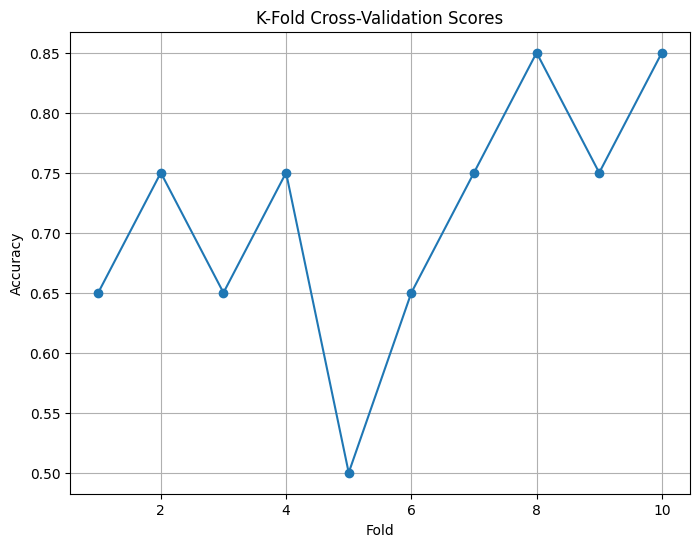

Mean CV score: 0.7149999976158142
Standard deviation of CV scores: 0.10012493304513648
Cross-validation scores: [0.6499999761581421, 0.75, 0.6499999761581421, 0.75, 0.5, 0.6499999761581421, 0.75, 0.8500000238418579, 0.75, 0.8500000238418579]
DataFrame:
   Fold  Accuracy
0     1      0.65
1     2      0.75
2     3      0.65
3     4      0.75
4     5      0.50
5     6      0.65
6     7      0.75
7     8      0.85
8     9      0.75
9    10      0.85


In [259]:
cross_val_scores, mean_score, std_score, cv_scores_df = k_fold_cross_validation(CNN_img_ai_or_hum_realism_1_10, realism_1_10_ts_ds, 10)
print("Mean CV score:", mean_score)
print("Standard deviation of CV scores:", std_score)
print("Cross-validation scores:", cross_val_scores)
print("DataFrame:")
print(cv_scores_df)

## Train the 1/5 dataset

In [260]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

#create location for check point
current_dir = os.getcwd()
filename = 'trained_models/CNN_img_ai_or_hum_ukuiyoe_1_5.keras'
checkpoint_filepath = os.path.join(current_dir, filename)

# Define the file path where the model will be saved
CNN_img_ai_or_hum_realism_1_5_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
CNN_img_ai_or_hum_realism_1_5.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

CNN_img_ai_or_hum_realism_1_5_history = CNN_img_ai_or_hum_TRAIN_MODEL(CNN_img_ai_or_hum_realism_1_5, realism_1_5_tr_ds, realism_1_5_va_ds, CNN_img_ai_or_hum_realism_1_5_checkpoint)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5130 - loss: 458.6862
Epoch 1: val_accuracy improved from -inf to 0.57500, saving model to c:\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\trained_models/CNN_img_ai_or_hum_ukuiyoe_1_5.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.5136 - loss: 447.7567 - val_accuracy: 0.5750 - val_loss: 0.7105
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6478 - loss: 0.6588
Epoch 2: val_accuracy improved from 0.57500 to 0.67000, saving model to c:\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\trained_models/CNN_img_ai_or_hum_ukuiyoe_1_5.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.6482 - loss: 0.6580 - val_accuracy: 0.6700 - val_loss: 0.6093
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7410 - loss: 0.5630
Epoch 3: val_accuracy improved from 0.67000 to 0.74250, saving model to c:\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\trained_models/CNN_img_ai_o

### Test and Review 1/5 dataset

In [261]:
CNN_img_ai_or_hum_realism_1_5_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

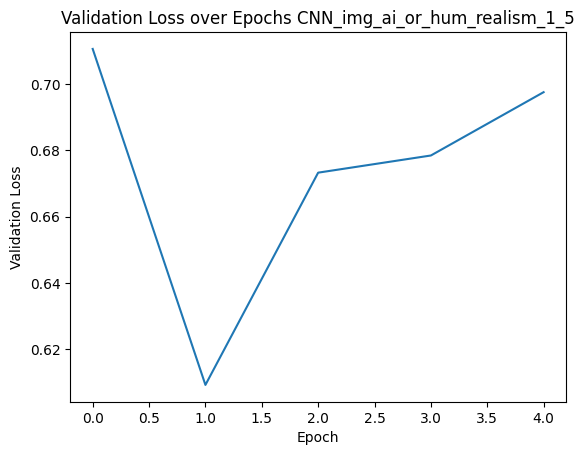

In [262]:
plt.plot(CNN_img_ai_or_hum_realism_1_5_history.history['val_loss']);
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs CNN_img_ai_or_hum_realism_1_5')
plt.show()

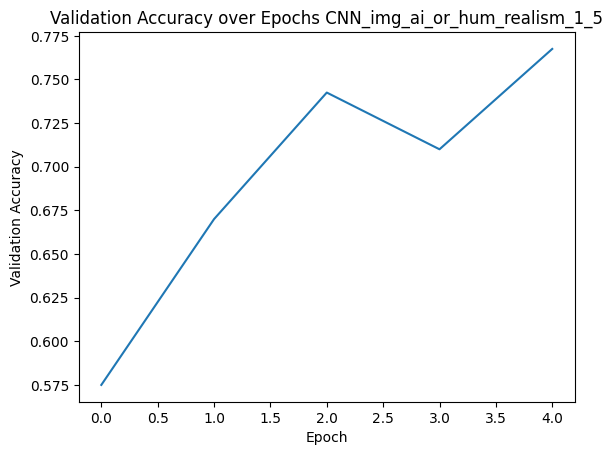

In [263]:
plt.plot(CNN_img_ai_or_hum_realism_1_5_history.history['val_accuracy']);
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs CNN_img_ai_or_hum_realism_1_5')
plt.show()

In [264]:
CNN_img_ai_or_hum_realism_1_5_predictions = CNN_img_ai_or_hum_realism_1_5.predict(realism_1_5_ts_ds)
CNN_img_ai_or_hum_realism_1_5_predictions

 94/400 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step


array([[0.4279692 , 0.49738175],
       [0.37747747, 0.49225333],
       [0.44567126, 0.48519665],
       [0.49869385, 0.5015795 ],
       [0.5014554 , 0.49701858],
       [0.5006492 , 0.49935076],
       [0.5006492 , 0.49935076],
       [0.3484017 , 0.5303949 ],
       [0.1658111 , 0.3570504 ],
       [0.4568046 , 0.51089287],
       [0.46890756, 0.4879539 ],
       [0.47286093, 0.5034558 ],
       [0.23417924, 0.48314774],
       [0.37231985, 0.4574271 ],
       [0.03354147, 0.2979265 ],
       [0.5006492 , 0.49935076],
       [0.5006492 , 0.49935076],
       [0.16162267, 0.32809705],
       [0.01526107, 0.2744255 ],
       [0.18499795, 0.29457113],
       [0.46617776, 0.5019229 ],
       [0.46248582, 0.4801502 ],
       [0.5006492 , 0.49935076],
       [0.49011233, 0.509531  ],
       [0.43385386, 0.456223  ],
       [0.12847865, 0.58751893],
       [0.4866134 , 0.4923393 ],
       [0.44723532, 0.46490476],
       [0.5006492 , 0.49935076],
       [0.3619783 , 0.43877545],
       [0.

In [265]:
realism_1_5_ts_ds.class_indices
print (realism_1_5_ts_ds)

In [266]:
CNN_img_ai_or_hum_realism_1_5_predictions = np.argmax(CNN_img_ai_or_hum_realism_1_5_predictions, axis = 1)
CNN_img_ai_or_hum_realism_1_5_predictions

array([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,

              precision    recall  f1-score   support

           0       0.55      0.42      0.47       200
           1       0.53      0.65      0.58       200

    accuracy                           0.54       400
   macro avg       0.54      0.54      0.53       400
weighted avg       0.54      0.54      0.53       400



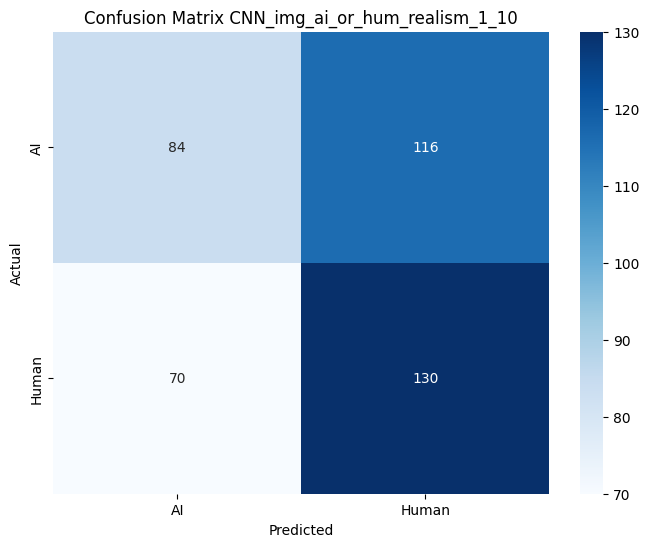

In [267]:
#import seaborn as sns 
#from sklearn.metrics import confusion_matrix, classification_report
#cm = confusion_matrix(test_dataset.classes, predictions)
#sns.heatmap(cm, annot=True)
#print(classification_report(test_dataset.classes, predictions))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix and classification report
cm = confusion_matrix(realism_1_5_ts_ds.classes, CNN_img_ai_or_hum_realism_1_5_predictions)
report = classification_report(realism_1_5_ts_ds.classes, CNN_img_ai_or_hum_realism_1_5_predictions)

# Define custom labels for the axes
labels = ['AI', 'Human']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

# Add labels to the axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix CNN_img_ai_or_hum_realism_1_10')

# Print classification report
print(report)

# Show the plot
plt.show()

### Testing with KFolds

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5935 - loss: 0.6344


c:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4824 - loss: 0.6702
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6785 - loss: 0.6001
     30/Unknown 1s 19ms/step - accuracy: 0.6011 - loss: 0.7169

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6179 - loss: 0.7011
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7068 - loss: 0.7313
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6879 - loss: 0.6239
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6872 - loss: 0.6621
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4949 - loss: 0.6455
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6824 - loss: 0.7335
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5616 - loss: 0.6712


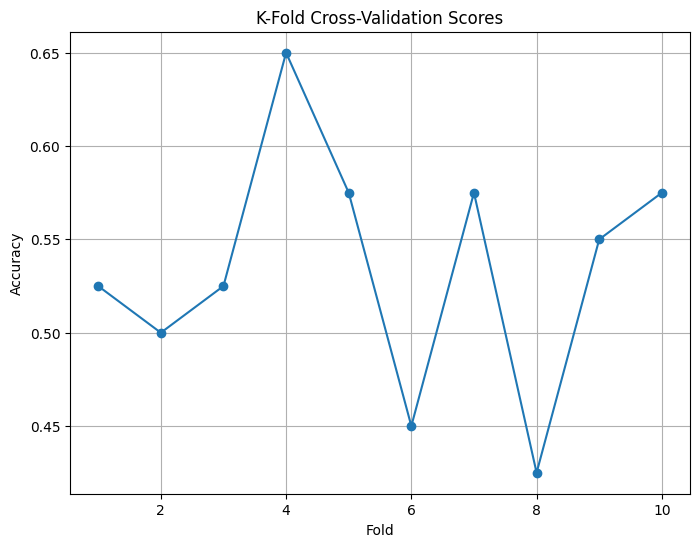

Mean CV score: 0.5349999904632569
Standard deviation of CV scores: 0.0624499738755807
Cross-validation scores: [0.5249999761581421, 0.5, 0.5249999761581421, 0.6499999761581421, 0.574999988079071, 0.44999998807907104, 0.574999988079071, 0.42500001192092896, 0.550000011920929, 0.574999988079071]
DataFrame:
   Fold  Accuracy
0     1     0.525
1     2     0.500
2     3     0.525
3     4     0.650
4     5     0.575
5     6     0.450
6     7     0.575
7     8     0.425
8     9     0.550
9    10     0.575


In [268]:
cross_val_scores, mean_score, std_score, cv_scores_df = k_fold_cross_validation(CNN_img_ai_or_hum_realism_1_5, realism_1_5_ts_ds, 10)
print("Mean CV score:", mean_score)
print("Standard deviation of CV scores:", std_score)
print("Cross-validation scores:", cross_val_scores)
print("DataFrame:")
print(cv_scores_df)

## Train the 1/2 dataset

In [269]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

#create location for check point
current_dir = os.getcwd()
filename = 'trained_models/CNN_img_ai_or_hum_realism_1_10.keras'
checkpoint_filepath = os.path.join(current_dir, filename)

# Define the file path where the model will be saved
CNN_img_ai_or_hum_realism_1_2_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
CNN_img_ai_or_hum_realism_1_2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

CNN_img_ai_or_hum_realism_1_2_history = CNN_img_ai_or_hum_TRAIN_MODEL(CNN_img_ai_or_hum_realism_1_2, realism_1_2_tr_ds, realism_1_2_va_ds, CNN_img_ai_or_hum_realism_1_2_checkpoint)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5083 - loss: 317.7487
Epoch 1: val_accuracy improved from -inf to 0.76875, saving model to c:\Users\krishna b\Desktop\COMP3610\Real_AI_SD_LD_Dataset\trained_models/CNN_img_ai_or_hum_realism_1_10.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.5107 - loss: 308.8806 - val_accuracy: 0.7688 - val_loss: 0.6096
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7558 - loss: 0.5733
Epoch 2: val_accuracy did not improve from 0.76875
20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.7558 - loss: 0.5733 - val_accuracy: 0.7625 - val_loss: 0.5440
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8313 - loss: 0.4996
Epoch 3: val_accuracy did not improve from 0.76875
20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.8318 - loss: 0.4979 - val_accuracy: 0.7094 - val_loss: 0.6676
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7846 - loss: 0.5379
Epoch 4: val_accuracy did not improve 

### Test and REview 1/2 dataset

In [270]:
CNN_img_ai_or_hum_realism_1_2_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

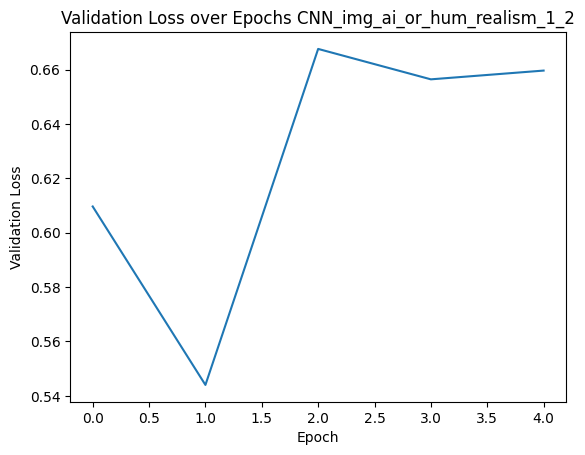

In [271]:
plt.plot(CNN_img_ai_or_hum_realism_1_2_history.history['val_loss']);
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs CNN_img_ai_or_hum_realism_1_2')
plt.show()

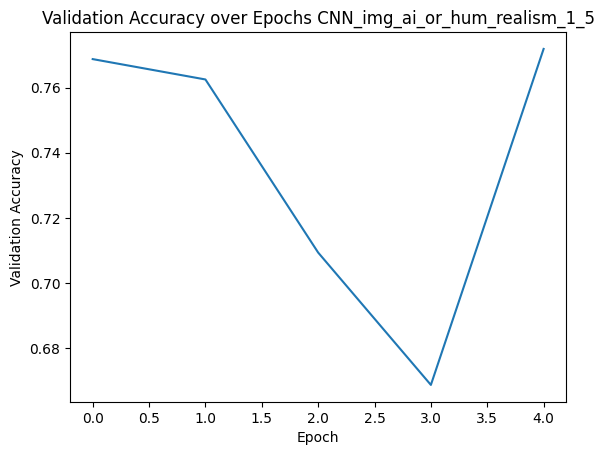

In [272]:
plt.plot(CNN_img_ai_or_hum_realism_1_2_history.history['val_accuracy']);
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs CNN_img_ai_or_hum_realism_1_5')
plt.show()

In [273]:
CNN_img_ai_or_hum_realism_1_2_predictions = CNN_img_ai_or_hum_realism_1_2.predict(realism_1_2_ts_ds)
CNN_img_ai_or_hum_realism_1_2_predictions

 47/800 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step

800/800 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step


array([[0.49743208, 0.49966165],
       [0.4934352 , 0.5048892 ],
       [0.47848183, 0.509854  ],
       ...,
       [0.6586838 , 0.34904826],
       [0.8127962 , 0.15226707],
       [0.871968  , 0.13406056]], dtype=float32)

In [274]:
realism_1_2_ts_ds.class_indices
print (realism_1_2_ts_ds)

In [275]:
CNN_img_ai_or_hum_realism_1_2_predictions = np.argmax(CNN_img_ai_or_hum_realism_1_2_predictions, axis = 1)
CNN_img_ai_or_hum_realism_1_2_predictions

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       400
           1       0.76      0.74      0.75       400

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800



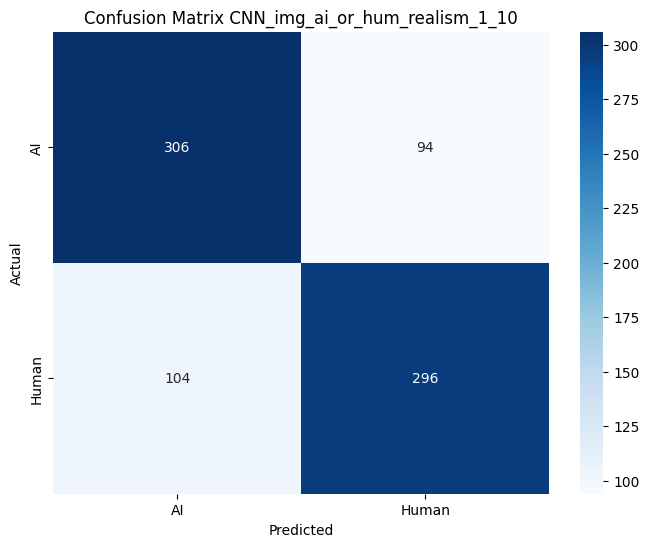

In [276]:
#import seaborn as sns 
#from sklearn.metrics import confusion_matrix, classification_report
#cm = confusion_matrix(test_dataset.classes, predictions)
#sns.heatmap(cm, annot=True)
#print(classification_report(test_dataset.classes, predictions))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix and classification report
cm = confusion_matrix(realism_1_2_ts_ds.classes, CNN_img_ai_or_hum_realism_1_2_predictions)
report = classification_report(realism_1_2_ts_ds.classes, CNN_img_ai_or_hum_realism_1_2_predictions)

# Define custom labels for the axes
labels = ['AI', 'Human']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

# Add labels to the axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix CNN_img_ai_or_hum_realism_1_10')

# Print classification report
print(report)

# Show the plot
plt.show()

### TEsting with KFold

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6551 - loss: 0.7197
      1/Unknown 0s 81ms/step - accuracy: 1.0000 - loss: 0.6623

c:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6931 - loss: 0.8180
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7341 - loss: 0.7367
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7555 - loss: 0.6718
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8209 - loss: 0.6228
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7212 - loss: 0.6537
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7143 - loss: 0.7140
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8089 - loss: 0.6029
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8494 - loss: 1.1596
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7521 - loss: 1.1172


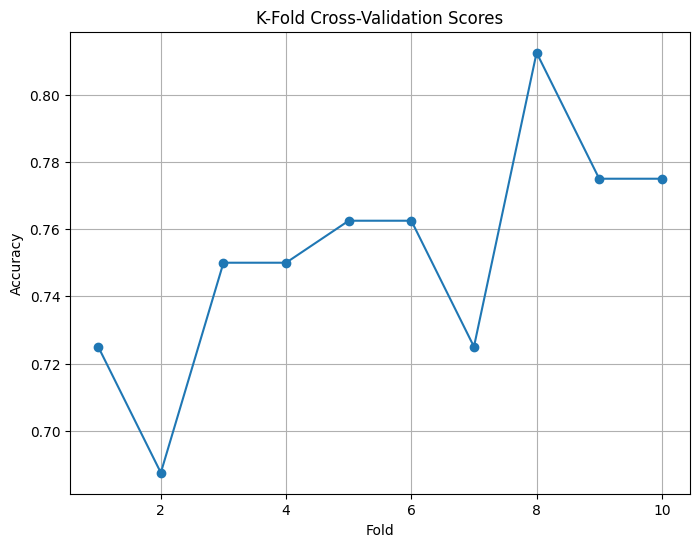

Mean CV score: 0.7524999976158142
Standard deviation of CV scores: 0.03249999193045094
Cross-validation scores: [0.7250000238418579, 0.6875, 0.75, 0.75, 0.762499988079071, 0.762499988079071, 0.7250000238418579, 0.8125, 0.7749999761581421, 0.7749999761581421]
DataFrame:
   Fold  Accuracy
0     1    0.7250
1     2    0.6875
2     3    0.7500
3     4    0.7500
4     5    0.7625
5     6    0.7625
6     7    0.7250
7     8    0.8125
8     9    0.7750
9    10    0.7750


In [277]:
cross_val_scores, mean_score, std_score, cv_scores_df = k_fold_cross_validation(CNN_img_ai_or_hum_realism_1_2, realism_1_2_ts_ds, 10)
print("Mean CV score:", mean_score)
print("Standard deviation of CV scores:", std_score)
print("Cross-validation scores:", cross_val_scores)
print("DataFrame:")
print(cv_scores_df)